In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

For this exercise we will work through the different steps of a linear regression workflow.  We will:

### 1. FSM
- Load in the dataset: inspect the overall shape, duplicate entries, and na's.
- Identify the continuous target variable
- Perform Initial EDA: correlation plots
- Build a FSM (First Simple Model) with statsmodels/Build a FSM with sklearn
- Check the assumptions of linear regression  

### 2. Iterate: Build a better model - Add another numerical feature
- Add another feature, this time with high negative correlation, and fit the model
- Compare metrics and interpret coefficients
- Check the assumptions

### 3. Iterate: Build a better model - Add a categorical feature
- Add a categorical variable 
- Compare metrics and interpret coefficients
- Check the assumptions once-again

### 4. Appendix
- Next steps

## The Dataset
We will use a dataset from [Kaggle](https://www.kaggle.com/kumarajarshi/life-expectancy-who). It contains data collected by the WHO about life expectancy and potentially-related factors.  The information is aggregated on a per-country per-year basis.

The following questions have been posed. Read them and keep them in your mind when building your model.  We will reference them as we proceed through the workflow.

1. Do various predicting factors which have been chosen initially really affect life expectancy? Which predicting variables actually affect life expectancy?
2. Should a country having a lower life expectancy value(<65) increase its healthcare expenditure in order to improve its average lifespan?
3. How do infant and adult mortality rates affect life expectancy?
4. Does life expectancy have positive or negative correlation with eating habits, lifestyle, exercise, smoking, drinking alcohol etc.
5. What is the impact of schooling on the lifespan of humans?
6. Does Life expectancy have positive or negative relationship with drinking alcohol?
7. Do densely populated countries tend to have lower life expectancy?
8. What is the impact of immunization coverage on life Expectancy?

# 1. FSM

### Load in the dataset and check the overall shape


In [109]:
# load in the dataset
df = None

# How many records are in the data set?
records = None

# How many columns are in the dataset?
columns = None

# Check for duplicate entries

# Check for na's (just look to get an idea; don't drop or impute yet)


### What does a row in the dataframe represent?


In [ ]:
# Your answer here

### Identify the continous target variable

If you had problems isolating that variable, don't worry.  That is on purpose! 
There can be odd, burdensome inconsistencies in naming of data.
Let's use our Python skills to wipe out the naming inconsistencies.

### Clean up the column names. 
There are many ways to do this. One way of doing so, outlined below, uses the columns attribute of the dataframe.  Then, using a list comprehension or for loop, we can manipulate the column name strings using methods that come with the string class.

In [112]:
# 1. Gather column names into a variable
columns = None

# 2. Strip whitespace from the ends
columns = None

# 3. Replace white space with underscores
columns = None

# 4. Make all columns characters lowercase
columns = None

# 5. Reset the column names of the dataframe
# df.columns = columns

In [145]:
df.head()

,life_expectancy,country,year,status,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness__1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
0,65.0,Afghanistan,2015,Developing,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,59.9,Afghanistan,2014,Developing,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,59.9,Afghanistan,2013,Developing,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,59.5,Afghanistan,2012,Developing,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,59.2,Afghanistan,2011,Developing,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [114]:
# Lastly, to make things easier to interpet, set the target to column index 0


In [117]:
# Revisit the continuous target variable.  
# Explore it a bit.  Plot a histogram of its distribution as well a boxplot

## Perform Initial EDA

There are a lot of variables here!  Let's look at a correlation matrix to see which ones might be the most useful.  (Here we are looking for variables that are highly correlated with the target variable, but not highly correlated with other input variables)

In [120]:
# create a correlation matrix
# first, just use the datafram .corr() method to output a numerical matrix


In [121]:
# Then pass the above code into Seaborn's heatmap plot


In [122]:
# Try adding the code in this cell to the mask attribute in the heatmap to halve the plot
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))

In [124]:
# Judging from the correlation matrix or the heatmap, which three features have the highest positive correlation? 


Use seaborn's pairplot function on the three features above plus life_expectancy.  
Note: we would usually start right off by using a pairplot, but because we have so many features, the pairplot would be unwieldy.

In [ ]:
# your code here

Judging from the top row of the pairplot, one feature's correlation to the target is a bit fuzzier than the rest. 
Inspecting other cells of the pairplot, the other two features show covariance. 
Given those two insights, choose one feature to build the First Simple Model with.
Consider also whether choosing one of the positively correlated features above the others would help answer any of the question listed at the beginning of the notebook.


## FSM with Statsmodels


In [133]:
from statsmodels.formula.api import ols
# Create a dataframe with only the target and the chosen high-positive corellation feature
fsm_df = None
# For this FSM, simply dropnas.

# build the R-style formula. The format is "target~feature_1 + feature_2 + feature_3"
formula = None

# Fit the model on the dataframe composed of the two features
fsm = ols(formula=formula, data=fsm_df).fit()

In [143]:
# Use the summary() method on the fsm varaible to print out the results of the fit.
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     3599.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:44:43   Log-Likelihood:                -8964.3
No. Observations:                2768   AIC:                         1.793e+04
Df Residuals:                    2766   BIC:                         1.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     44.1089      0.437    100.992      0.000      43.252      44.965
schooling      2.1035      0.035     59.995      0.000       2.035       2.172
==============================================================================
Omnibus:                      283.391   Durbin-Watson:                   0.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1122.013
Skew:                          -0.445   Prob(JB):                    2.28e-244
Kurtosis:                       5.989   Cond. No.                         46.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [163]:
# The object also has attributes associated with the ouput, such as: rsquared, and params.
# save those values to the variables below.

rsquared = None
params = None

print(f'Rsquared of FSM: {rsquared}')
print('----------')
print('Beta values of FSM:')
print(params)

Rsquared of FSM: None
----------
Beta values of FSM:
None


Interpret the result of the FSM.  What does the R Squared tell you? Remember the formula for:

$\Large R^2 = 1 - \frac{SSE}{SST}$

Also, interepret the coefficients.  If we increase the value of our independent variable by 1, what does it mean for our predicted value?

What is will our model predict the value of Life Expectancy to be for a country with 0 years of school on average?

In [ ]:
# Your answer here

# Check the assumptions of Linear Regression

#### 1. Linearity

Linear regression assumes that the input variable linearly predicts the output variable.  We already qualitatively checked that with a scatter plot.  But I also think it's a good idea to use a statistical test.  This one is the [Rainbow test](https://www.tandfonline.com/doi/abs/10.1080/03610928208828423) which is available from the [diagnostic submodule of StatsModels](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.linear_rainbow.html#statsmodels.stats.diagnostic.linear_rainbow)

In [167]:
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

rainbow_statistic, rainbow_p_value = linear_rainbow(fsm)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.2910159786411675
Rainbow p-value: 1.057579656507341e-06


The null hypothesis is that the model is linearly predicted by the features, alternative hypothesis is that it is not.  Thus returning a low p-value means that the current model violates the linearity assumption.

#### 2. Normality

Linear regression assumes that the residuals are normally distributed.  It is possible to check this qualitatively with a Q-Q plot.  The fit model object has an attribute called resid, which is an array of the difference between predicted and real values.  Store the residuals in the variable below, show the qq plot, and interepret. You are looking for the theoretical quantiles and the sample quantiles to line up.

In [228]:
# Create a qq-plot

fsm_resids = None

import statsmodels.api as sm
sm.qqplot(fsm_resids)

AttributeError: 'NoneType' object has no attribute 'shape'

Those qqplots don't look so good in the upper right corner.

The [Jarque-Bera](https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test) test is performed automatically as part of the model summary output, labeled **Jarque-Bera (JB)** and **Prob(JB)**.

The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not.  
What does the JB score output indicate. Does it support the qq-plot?

In [230]:
# Your answer here

In [232]:
# Your answer here

#### 3. Homoscadasticity

Linear regression assumes that the variance of the dependent variable is homogeneous across different value of the independent variable(s).  We can visualize this by looking at the predicted life expectancy vs. the residuals.



In [233]:
# Use the predict() method now available to be called from the fsm variable to store the predictions
y_hat = None

# plot y_hat against the residuals (stored in fsm_resids) in a scatter plot



Interepret the result. Do you see any patterns that suggest that the residuals exhibit heteroscedasticity?


Let's also run a statistical test.  The [Breusch-Pagan test](https://en.wikipedia.org/wiki/Breusch%E2%80%93Pagan_test) is available from the [diagnostic submodule of StatsModels](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_breuschpagan.html#statsmodels.stats.diagnostic.het_breuschpagan)

In [236]:
# If you chose schooling, this should run without error
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(fsm_resids, fsm_df[["schooling"]])
print("Lagrange Multiplier p-value:", lm_p_value)
print("F-statistic p-value:", f_p_value)

Lagrange Multiplier p-value: nan
F-statistic p-value: 2.2825932549972298e-67


The null hypothesis is homoscedasticity, alternative hypothesis is heteroscedasticity.  
What does the p-value returned above indicate?

#### 4. Independence

The independence assumption means that the independent variables must not be too collinear.  Right now we have only one independent variable, so we don't need to check this yet.

## Train a model with sklearn
The sklearn interface is simpler than Statsmodels, but it does not give us the super helpful statsmodel output.  We will, however, use its syntax consistently with other algorithms.  

In [267]:
from sklearn.linear_model import LinearRegression

# fit an sklearn model
#instantiate a linear regression object 
lr = None

# split the data into target and features
y = None
X = None

# Call .fit from the linear regression object, and feed X and y in as parameters


# lr has a method called score.  Again, feed in X and y, and read the output. Save it in the variable score.  What is that number?  Compare it to statsmodels. 
score = None

# lr also has attributes coef_ and intercept_. Save and compare to statsmodels
beta = None
intercept = None

# 2. Iterate: Build a better model - Add another numerical feature

## Adding Features to the Model

So far, all we have is a simple linear regression.  Let's start adding features to make it a multiple regression.

Let's repeat the process of the highly positively correlated variables, but this time with the highly negatively correlated variables (based on looking at the correlation matrix)

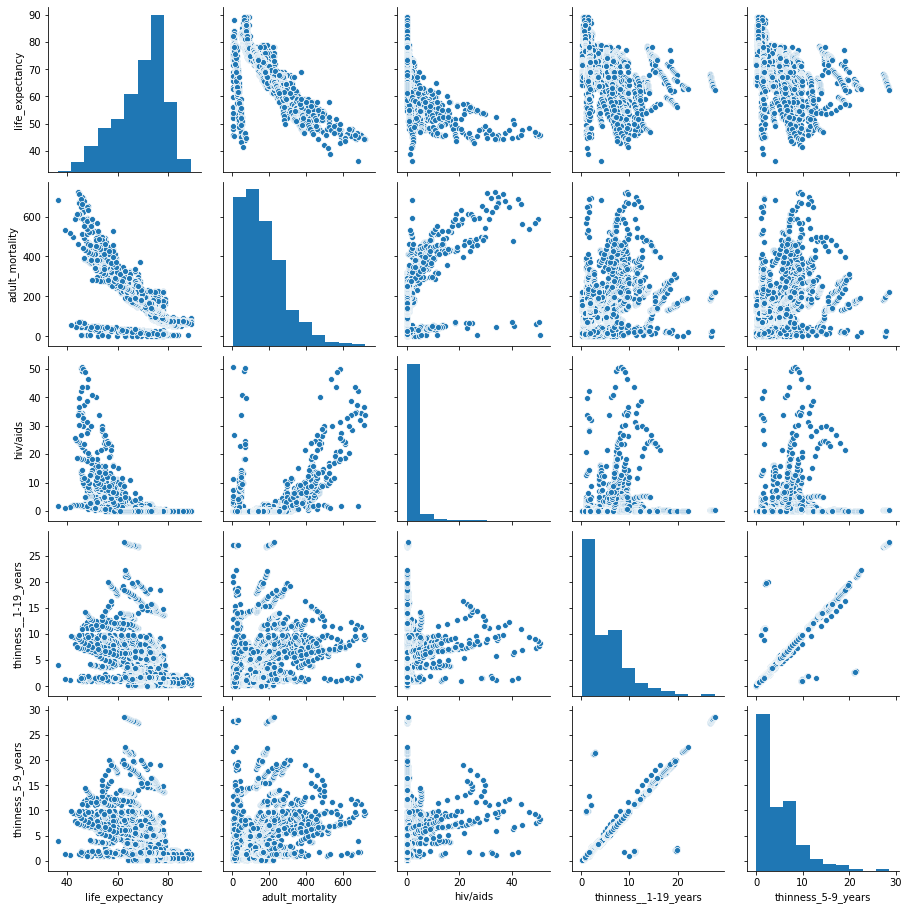

In [227]:
negatively_correlated_cols = [
    'life_expectancy',
    'adult_mortality',
    'hiv/aids',
    'thinness__1-19_years',
    'thinness_5-9_years'
]
negatively_correlated_df = df[negatively_correlated_cols]
sns.pairplot(negatively_correlated_df);

In [225]:
df.head()

,life_expectancy,country,year,status,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness__1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
0,65.0,Afghanistan,2015,Developing,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,59.9,Afghanistan,2014,Developing,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,59.9,Afghanistan,2013,Developing,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,59.5,Afghanistan,2012,Developing,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,59.2,Afghanistan,2011,Developing,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


`adult_mortality` seems most like a linear relationship.  Also, the two thinness metrics seem to be providing very similar information, so we almost certainly should not include both

Let's proceed with adult mortality.

In [264]:
# Create another dataframe containing our three features of interest
model_2 = None

# Drop na's across all columns


# save the R-like formula into the variable
formula = None

# train the model like we did above
model_2

# print out the summary table


### Did the r_2 improve? 
Your answer here

In [377]:
Now check the assumptions like we did above.

SyntaxError: invalid syntax (<ipython-input-377-533dd3775036>, line 1)

In [378]:
## Linearity



In [380]:
## Normality



In [382]:
## Homoscadasticity




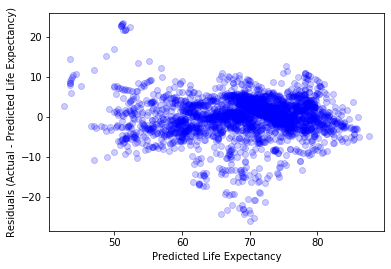

In [383]:
y_hat = model_2.predict()
model_2_resids = model_2.resid

fig4, ax4 = plt.subplots()
ax4.set(xlabel="Predicted Life Expectancy",
        ylabel="Residuals (Actual - Predicted Life Expectancy)")
ax4.scatter(x=y_hat, y=model_2_resids, color="blue", alpha=0.2)

In [386]:
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-y_hat, model_2_df[["schooling", "adult_mortality"]])
print("Lagrange Multiplier p-value:", lm_p_value)
print("F-statistic p-value:", f_p_value)

'''Both visually and numerically, we can see some improvement. 
But we are still violating this assumption to a statistically significant degree.'''

Lagrange Multiplier p-value: 3.8946545111368395e-47
F-statistic p-value: 1.2521305604484036e-47


'Both visually and numerically, we can see some improvement. \nBut we are still violating this assumption to a statistically significant degree.'

## Independence

You might have noticed in the regression output that there was a warning about the condition number being high. The condition number is a measure of stability of the matrix used for computing the regression (we'll discuss this more in the next module), and a number above 30 can indicate strong multicollinearity. Our output is way higher than that.

A different (more generous) measure of multicollinearity is the variance inflation factor. It is available from the outlier influence submodule of StatsModels.

Run the code below:

In [388]:
rows = model_2_df[["schooling", "adult_mortality"]].values

vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(2)]
vif_df["feature"] = ["schooling", "adult_mortality"]

vif_df

,VIF,feature
0,1.937556,schooling
1,1.937556,adult_mortality


A "rule of thumb" for VIF is that 5 is too high.  Given the output above, it's reasonable to say that we are not violating the independence assumption, despite the high condition number.

### 3. Iterate: Build a better model - Add a categorical feature


This is less realistic than the previous steps, but is good for demonstartion purposes.

In this dataset, we have a lot of numeric values (everything in that correlation matrix), but there are a few that aren't.  One example is `Status`

In [281]:
# Check out what Seaborn's catplot does
# https://seaborn.pydata.org/generated/seaborn.catplot.html

# Plot status vs life expectancy.  Choose a kind of plot to pass into the kind parameter


It looks like there is a difference between the two groups that might be useful to include

There are only two categories, so we only need a `LabelEncoder` that will convert the labels into 1s and 0s.  If there were more than two categories, we would use a `OneHotEncoder`, which would create multiple columns out of a single column.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# instantiate and instance of LabelEncoder
label_encoder = None

# Pass the "status" column of the model_3_df to the fit_transform() method of the Label Encoder
status_labels = None


In [ ]:
# Run the code below.  The category Developing/Developed has been transformed to a binary
np.unique(status_labels, return_counts=True)

In [286]:
# Run the code below to see the classes associated with 1 and 0
label_encoder.classes_

array(['Developed', 'Developing'], dtype=object)

This is telling us that "Developed" is encoded as 0 and "Developing" is encoded as 1.  This means that "Developed" is assumed at the intercept.

In [ ]:
# Add the status labels array to the model_df as a column 
model_3_df["status_encoded"] = None

# Drop the status column

In [299]:
"+".join(model_3_df.iloc[:,1:].columns)

'schooling+adult_mortality+status_encoded'

In [304]:
# Fit the 3rd model

# assign the new formula

formula="life_expectancy~" + "+".join(model_3_df.iloc[:,1:].columns)

# fit the new model
model_3 = ols(formula=formula, data=model_3_df).fit()

# print the summary
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     2350.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        20:44:17   Log-Likelihood:                -8364.0
No. Observations:                2768   AIC:                         1.674e+04
Df Residuals:                    2764   BIC:                         1.676e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          58.9976      0.634     93.014      0.000      57.754      60.241
schooling           1.4447      0.035     40.772      0.000       1.375       1.514
adult_mortality    -0.0324      0.001    -37.395      0.000      -0.034      -0.031
status_encoded     -2.0474      0.296     -6.910      0.000      -2.628      -1.466
==============================================================================
Omnibus:                      570.672   Durbin-Watson:                   0.678
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2798.757
Skew:                          -0.899   Prob(JB):                         0.00
Kurtosis:                       7.586   Cond. No.                     1.45e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Third Model Evaluation
 Your answer here

In [ ]:
# Let's look at the model assumptions again

#### Linearity

In [41]:
rainbow_statistic, rainbow_p_value = linear_rainbow(model_3)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0769559317010546
Rainbow p-value: 0.08416346182745871


In [ ]:
# Did linearity improve


In [ ]:
#_SOLUTION__
Another small improvement

#### Normality
Did our errors become more normally distributed?

Your answer here

#### Homoscadasticity

Did our homoscadasticity improve?

In [ ]:
model_3_resids = None
y_hat = None

fig, ax = plt.subplots()

ax.scatter(y_hat, model_3_resids)

In [ ]:
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-y_hat, model_3_df[["schooling", "adult_mortality", "status_encoded"]])
print("Lagrange Multiplier p-value:", lm_p_value)
print("F-statistic p-value:", f_p_value)

#### Independence

In [316]:
rows = model_3_df[["schooling", "adult_mortality", "status_encoded"]].values

vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(3)]
vif_df["feature"] = ["schooling", "adult_mortality", "status_encoded"]

vif_df

,VIF,feature
0,3.120074,schooling
1,2.838221,adult_mortality
2,4.518962,status_encoded


What does the above output tell you?

Your answer here

Below, you will find an example summary of how one might use the linear regression models shown above to address the questions posed at the beginning of the notebook.

# Summary
We started with a baseline model where the only input feature was Schooling. Our baseline model had an r-squared of 0.565. This model violated the linearity (p < 0.001), normality (p < 0.001), and homoscadasticity (p < 0.001) assumptions of linear regression. The independence assumption was met by default because there was only one input feature.

The final model for this lesson had three input features: Schooling, Adult_Mortality, and Status_Encoded. It had an r-squared of 0.718. This model did not violate the linearity assumption (p = 0.084), but it did violate the normality (p < 0.001) and homoscedasticity (p < 0.001) assumptions. Based on the variance inflaction factor metric, it did not violate the independence assumption.

We are able to address the following questions from above:

1. Does various predicting factors which has been chosen initially really affect the Life expectancy? What are the predicting variables actually affecting the life expectancy?

With only 3 features we are able to explain about 71% of the variance in life expectancy. This indicates that these factors truly are explanatory. More analysis is required to understand how much additional explanatory power would be provided by incorporating additional features into the model.

3. How do Infant and Adult mortality rates affect life expectancy?

So far we have only investigated adult mortality. The adult mortality rate ("probability of dying between 15 and 60 years per 1000 population") has a negative correlation with life expectancy. For each increase of 1 in the adult mortality rate, life expectancy decreases by about .03 years.

5. What is the impact of schooling on the lifespan of humans?

In our latest model, we find that each additional year of average schooling is associated with 1.4 years of added life expectancy. However it is challenging to interpret whether it is schooling that is actually having the impact. Schooling is highly correlated with Income_Composition_of_Resources ("Human Development Index in terms of income composition of resources") so it is very possible that schooling is the result of some underlying factor that also impacts life expectancy, rather than schooling impacting life expectancy directly.

### 4. Further exercises

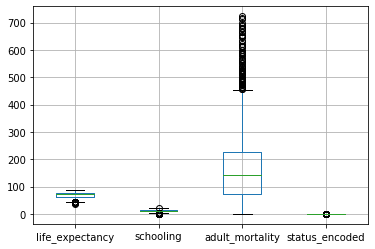

In [389]:
### Remove outliers

# Run a boxplot on the model_3_df
model_3_df.boxplot()

In [402]:
# There are a a significant amount of outliers in adult mortality giving the distribution a heavy right skew

In [405]:
model_3_df_no_am_fliers = model_3_df[np.abs(stats.zscore(model_3_df['adult_mortality'])<3)]

# Fit the 3rd model
# assign the new formula

formula="life_expectancy~" + "+".join(model_3_df_no_am_fliers.iloc[:,1:].columns)

# fit the new model
model_3_no_am_fliers = ols(formula=formula, data=model_3_df_no_am_fliers).fit()

# print the summary
model_3_no_am_fliers.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     2084.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        21:32:57   Log-Likelihood:                -8221.8
No. Observations:                2726   AIC:                         1.645e+04
Df Residuals:                    2722   BIC:                         1.648e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          58.0113      0.644     90.122      0.000      56.749      59.273
schooling           1.4876      0.036     41.661      0.000       1.418       1.558
adult_mortality    -0.0286      0.001    -29.073      0.000      -0.031      -0.027
status_encoded     -2.0926      0.295     -7.098      0.000      -2.671      -1.514
==============================================================================
Omnibus:                      507.372   Durbin-Watson:                   0.597
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2548.934
Skew:                          -0.796   Prob(JB):                         0.00
Kurtosis:                       7.462   Cond. No.                     1.36e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Appendix
Things we have not done in this lesson, but that you should consider in your project:  

More robust cleaning (possible imputation of missing values, principled exclusion of some data)  
Feature scaling  
Nearest-neighbors approach (requires more complex feature engineering)  
Pulling information from external resources  
Removing independent variables if you determine that they are causing too high of multicollinearity  
Setting up functions so the code is not so repetitive  